#### Vehicular Coordination for lane change prediction

    AIM - Develop a driver assist system to aid in lane change and overtaking decision making.

    OBJECTIVE - To minimise the rate of collissions related to overtaking and lane change maneuvres.

##### Import requisite modules

In [1]:
import numpy as np
import pickle
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import os
import platform
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
pickle.format_version

'4.0'

#### Check Library Versions

In [3]:
print(f"Numpy Version: {np.__version__}")
print(f"Torch Version: {torch.__version__}")
version = platform.python_version()
print("Python : ",version)

Numpy Version: 1.19.5
Torch Version: 1.12.0+cpu
Python :  3.8.10


##### Set Seed to ensure result reproducibility

In [4]:
SEED = 42
def set_seed(SEED):
    np.random.seed = SEED
    os.environ['PYTHONHASHSEED'] = str(SEED)
    

set_seed(SEED)
# Defines how random numbers are reproduced
torch.manual_seed(SEED)

#### Load Previously Preprocessed

In [5]:
# Load stored pickle objects
input_data = []
for i in range(1, 61):
    idx_str = '{0:02}'.format(i)
    pickle_in = open("output/result"+idx_str+".pickle", "rb") # read binary pickle object
    temp_data = pickle.load(pickle_in)
    print("Loaded "+idx_str+" data pack")
    input_data.extend(temp_data)

Loaded 01 data pack
Loaded 02 data pack
Loaded 03 data pack
Loaded 04 data pack
Loaded 05 data pack
Loaded 06 data pack
Loaded 07 data pack
Loaded 08 data pack
Loaded 09 data pack
Loaded 10 data pack
Loaded 11 data pack
Loaded 12 data pack
Loaded 13 data pack
Loaded 14 data pack
Loaded 15 data pack
Loaded 16 data pack
Loaded 17 data pack
Loaded 18 data pack
Loaded 19 data pack
Loaded 20 data pack
Loaded 21 data pack
Loaded 22 data pack
Loaded 23 data pack
Loaded 24 data pack
Loaded 25 data pack
Loaded 26 data pack
Loaded 27 data pack
Loaded 28 data pack
Loaded 29 data pack
Loaded 30 data pack
Loaded 31 data pack
Loaded 32 data pack
Loaded 33 data pack
Loaded 34 data pack
Loaded 35 data pack
Loaded 36 data pack
Loaded 37 data pack
Loaded 38 data pack
Loaded 39 data pack
Loaded 40 data pack
Loaded 41 data pack
Loaded 42 data pack
Loaded 43 data pack
Loaded 44 data pack
Loaded 45 data pack
Loaded 46 data pack
Loaded 47 data pack
Loaded 48 data pack
Loaded 49 data pack
Loaded 50 data pack


### Sample Data Format and Feature Relevance
The data is loaded in the following format as was previously stored
<ol>
   <li>Left Lane Exists</li>
        Indicates whether the left lane exist

   <li> Right Lane Exists</li>
        Indicates whether the right lane exist
    
   <li>Difference of the ego car’s Y position and the lane center: ΔY</li>

   <li> Ego car’s X velocity: Vx</li>
        The longitudinal velocity in the image coordinate system.
   <li> Ego car’s Y velocity: Vy</li>
        The lateral velocity in the image coordinate system.
   <li> Ego car’s X acceleration: Ax</li>
        The longitudinal acceleration in the image coordinate system
   <li> Ego car’s Y acceleration: Ay</li>
        The longitudinal acceleration in the image coordinate system
   <li> Ego car type: T</li>
        Indicates the car type. 1 for car and -1 for truck
    
   <li> TTC of preceding car: TTCp</li>
        Units are expressed in seconds, a value of 99999 indicates no emminent collision exists.
        TTC is basically used as a measure to show the relative closeness of a vehicle to the ego vehicleto warrant a collision
    
   <li> TTC of following car: TTCf</li>
    
   <li> TTC of left preceding car: TTClp</li>
    
   <li> TTC of left alongside car: TTCla</li>
    
  <li>  TTC of left following car: TTClf</li>
    
   <li>TTC of right preceding car: TTCrp</li>
    
   <li> TTC of right alongside car: TTCra</li>
    
   <li>TTC of right following car: TTCrf</li>
</ol>

In [6]:
# sample dataset format
# The following shows a single data sample from a single vehicle dynamics.
input_data[1][0][0]


(0,
 1,
 0.2699999999999996,
 0.39,
 0.27,
 -30.84,
 0.07,
 1,
 99999,
 99999,
 99999,
 99999,
 99999,
 99999,
 99999,
 2.010886469673405)

From the above data sample, it is evident that the left lane doesn't exist. This is the lane on the top.
The right lane exists/
Its relative positioning from the lanes centre.



##### Confirm loaded data and split data into training and testing sets.

In [7]:
# Examine the number of samples loaded from storage bucket
print(f"{len(input_data)} data samples available")
# Split data into training and sampling set
size = len(input_data)
training_set = input_data[:int(size*0.8)]
testing_set = input_data[int(size*0.8):]

print(f"Training size: {len(training_set)}")
print(f"Testing size: {len(testing_set)}")

17592 data samples available
Training size: 14073
Testing size: 3519


## Model Building,Training and Testing

## LSTM
Applies a multi-layer long short-term memory (LSTM) RNN to an input sequence.
For each element in the input sequence, each layer computes the following function:
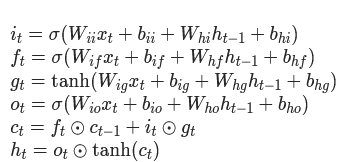


### Hyparameter tuning and selection

In [8]:
# set hyper-parameters
state_dim = 16
states_per_sequence = 50
hidden_dim = 256
output_size = 3
num_epoch = 10
num_lstm_layers = 3

### Model Building

In [9]:
class PredicterRNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_size, batch_size, num_layers):
        super(PredicterRNN, self).__init__()
        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        
        # input_dim – The number of expected features in the input x
        # hidden_dim – The number of features in the hidden state h

        # num_layers – Number of recurrent layers. E.g., setting num_layers=2 would mean stacking two LSTMs together to form 
        # a stacked LSTM, with the second LSTM taking in outputs of the first LSTM and computing the final results
        
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.batch_size = batch_size
        
        ## During training, randomly zeroes some of the elements of the input tensor with
        ## probability p using samples from a Bernoulli distribution. 
        ## Each channel will be zeroed out independently on every forward call.
        
        ## effective technique for regularization and preventing the co-adaptation of neurons 
        self.dropout_layer = nn.Dropout(p=0.2)
        
        
        ## 
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers)

        # The linear layer that maps from hidden state space to output space
        # Applies a linear transformation to the incoming data
        self.dense1 = nn.Linear(hidden_dim, int(hidden_dim/2))
        self.dense2 = nn.Linear(int(hidden_dim/2), output_size)

    # def init_hidden(self):
    #     # This is what we'll initialise our hidden state as
    #     return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
    #             torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))

    
    def forward(self, input):
        input = input.view(-1, 25, 16)
        # print(input.size())
        # .view(state_dim, self.batch_size, -1))
        lstm_out, _ = self.lstm(input)

        output_space = self.dense1(lstm_out.view(self.batch_size, -1))
        output_space = torch.tanh(output_space)
        #output_space = self.dropout_layer(output_space)
        output_space = self.dense2(output_space)
        output_space = torch.tanh(output_space)
        output_scores = F.log_softmax(output_space, dim=1)
        return output_scores


    
model = PredicterRNN(state_dim, hidden_dim, output_size,
                     states_per_sequence, num_lstm_layers)

### Loss Functions and Optimisation Functions

In [10]:
loss_function = nn.NLLLoss()
#loss_function = nn.MSELoss()
#optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
optimizer = optim.SGD(model.parameters(), lr=0.1)

### Perform Training

In [11]:
# load the data into pytorch
def prepare_sequence(state_sequence, tag):
    "PyTorch uses torch.tensor, rather than numpy arrays, so the data is converted in this step"
    s_seq_tensor = torch.tensor(state_sequence, dtype=torch.float)
    tag_list = [tag] * len(state_sequence)
    labels = torch.tensor(tag_list, dtype=torch.long)
    return s_seq_tensor, labels


loss_values = []
accuracy = []
false_alarm_rate = []
test_accuracy = []    
test_false_alarm_rate = []
for epoch in range(1, num_epoch+1):
    random.shuffle(training_set)
    start = time.time()
    total_num = 0
    total_loss = 0.0
    print(f"Epoch: {epoch}")
    print()
    for state_sequence, tag in training_set:
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        optimizer.zero_grad()

        # Step 2. Get our inputs ready for the network, that is, turn them into
        # Tensors of state sequences.
        sentence_in, label = prepare_sequence(state_sequence, tag)

        # Step 3. Run our forward pass.
        tag_scores = model(sentence_in)
        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        loss = loss_function(tag_scores, label)
        total_loss += loss.item()
        total_num += 1

        loss.backward()
        optimizer.step()
   
    
    # store the loss values
    loss_values.append(total_loss/total_num)
    end = time.time()
    print()
    print(f"Epoch: {epoch}  Total Loss : {total_loss/total_num}")
    print("\nEpoch", epoch, " run time:", end-start)
    
    print()
    print(f"Scores after Epoch: {epoch} Using training_set")
    print()
    
    # See what the scores are after an individual epoch training
    # The training set is used, this might not be the best way to test due to overfitting
    correct, total = 0, 0
    miss, false_alarm = 0, 0
    
    ## Context-manager that disabled gradient calculation.
    # Disabling gradient calculation is useful for inference, 
    # when you are sure that you will not call Tensor.backward(). 
    
    with torch.no_grad():
        for state_sequence, tag in training_set:
            sentence_in, label = prepare_sequence(state_sequence, tag)
            output_scores = model(sentence_in)
            _, idx = output_scores[-1].max(0)
            #print(f"Train Truth: {tag}  Train Predictions: {idx}")
            if tag != 0 and idx == 0:
                miss += 1
            if tag == 0 and idx != 0:
                false_alarm += 1
            if idx == tag:
                correct += 1
            total += 1
        
        # Store the accuracy and false rate after each epochs evaluations
        accuracy.append(correct/total)  
        false_alarm_rate.append(false_alarm/total)
        
        print(f"Epoch {epoch} False Alarm Rate  {false_alarm/total}  Miss rate  {miss/total}  Training accuracy: {correct/total}")

    
    
    # See what the scores are after testing
    correct, total = 0, 0
    miss, false_alarm = 0, 0
    print("Results using testing_test")

    with torch.no_grad():
        for state_sequence, tag in testing_set:
            sentence_in, label = prepare_sequence(state_sequence, tag)
            output_scores = model(sentence_in)
            _, idx = output_scores[-1].max(0)
            #print(f"Test Truth: {tag}  Test Predictions: {idx}")
            if tag != 0 and idx == 0:
                miss += 1
            if tag == 0 and idx != 0:
                false_alarm += 1
            if idx == tag:
                correct += 1
            total += 1
        
        test_accuracy.append(correct/total)
        test_false_alarm_rate.append(false_alarm/total)
        print(f"Epoch {epoch} False Alarm Rate  {false_alarm/total}  Miss rate  {miss/total}  Training accuracy: {correct/total}")




Epoch: 1


Epoch: 1  Total Loss : 0.7764500186481532

Epoch 1  run time: 339.53732681274414

Scores after Epoch: 1 Using training_set

Epoch 1 False Alarm Rate  0.20805798337241527  Miss rate  0.13280750373054787  Training accuracy: 0.5884317487387195
Results using testing_test
Epoch 1 False Alarm Rate  0.22477976697925547  Miss rate  0.1329923273657289  Training accuracy: 0.580278488206877
Epoch: 2


Epoch: 2  Total Loss : 0.7600376051543221

Epoch 2  run time: 329.1934244632721

Scores after Epoch: 2 Using training_set

Epoch 2 False Alarm Rate  0.13010729766219  Miss rate  0.16023591274070917  Training accuracy: 0.6598450934413416
Results using testing_test
Epoch 2 False Alarm Rate  0.13867576015913613  Miss rate  0.15373685706166523  Training accuracy: 0.658994032395567
Epoch: 3


Epoch: 3  Total Loss : 0.7606187626155109

Epoch 3  run time: 394.4728469848633

Scores after Epoch: 3 Using training_set

Epoch 3 False Alarm Rate  0.028707453989909756  Miss rate  0.3853478291764372  Tr

### Perform Visualisations of results

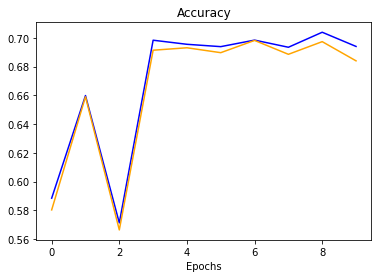

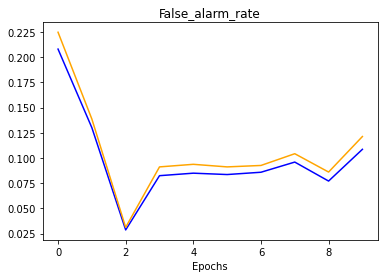

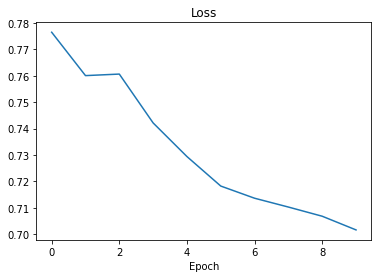

In [12]:
# Visualize the results after training and evaluation
plt.plot(accuracy,color ='blue')
plt.plot(test_accuracy,color ='orange')
plt.xlabel('Epochs')
plt.title('Accuracy')
plt.show()

plt.plot(false_alarm_rate,color ='blue')
plt.plot(test_false_alarm_rate,color ='orange')
plt.xlabel('Epochs')
plt.title('False_alarm_rate')
plt.show()


plt.plot(loss_values)
plt.xlabel('Epoch')
plt.title('Loss')
plt.show()


#### Discussion of results
It is  clear that the loss drops through every successive epoch training. It is possible that the training accuracy is bound
to increase with successive training, atleast until overfitting starts to occur.

It is critical that the model retains a minimal false alarm rate than a higher accuracy since for this use case, it is disastrous to have wrong predictions.

## Save model

In [13]:
## Save the model for later use
import joblib
joblib.dump(model, 'LSTMmodelLast.pkl')


['LSTMmodelLast.pkl']

In [14]:
joblib.__version__

'1.0.1'

#### Load saved model and predict on sample test_set

In [15]:

import joblib
lstm_saved = joblib.load('LSTMmodel.pkl')

## Perform predictions
correct, total = 0, 0
miss, false_alarm = 0, 0

with torch.no_grad():
        for state_sequence, tag in testing_set:
            sentence_in, label = prepare_sequence(state_sequence, tag)
            output_scores = lstm_saved(sentence_in)
            _, idx = output_scores[-1].max(0)
            
            if tag != 0 and idx == 0:
                miss += 1
            if tag == 0 and idx != 0:
                false_alarm += 1
            if idx == tag:
                correct += 1
            total += 1
        
            #test_accuracy.append(correct/total)
            #test_false_alarm_rate.append(false_alarm/total)
            
        print(f"False Alarm Rate  {false_alarm/total}  Miss rate  {miss/total}  Testing accuracy: {correct/total}")


False Alarm Rate  0.10201761864165956  Miss rate  0.15828360329639102  Testing accuracy: 0.7024722932651322


It is evident that with the small false alarm rate, the model better generalises to the data. The results are not bad but could be improved by better hyperparameter tuning which could be expensive(resource intensive)

### Prepare test data for inference


In [19]:
# Tensor objects are the efficient methods of data storage and efficient in neural network
# Operations.

def prepare_sequence(state_sequence, tag):
    "This method prepare our data in a format suitable for model consumption"
    
    "PyTorch uses torch.tensor, rather than numpy arrays, so the data is converted in this step"
    
    s_seq_tensor = torch.tensor(state_sequence, dtype=torch.float)
    tag_list = [tag] * len(state_sequence)
    labels = torch.tensor(tag_list, dtype=torch.long)
    return s_seq_tensor, labels


print(f'Number of samples in test set: {len(testing_set)}')
 
# Shuffle data to ensure variability
random.shuffle(testing_set)
infer = 1

# store tags to later use for evaluation
labels = {}
for state_sequence, tag in testing_set:
    if infer < 16:
        print(f'Stored Vehicle {infer} data')
        sentence_in, label = prepare_sequence(state_sequence, tag)
        pickle.dump(sentence_in,open(f'./inference_data/vehicle{infer}.pkl','wb'))
        labels[f'{infer}'] = tag
    infer += 1
    if infer > 15:
        break

Number of samples in test set: 3519
Stored Vehicle 1 data
Stored Vehicle 2 data
Stored Vehicle 3 data
Stored Vehicle 4 data
Stored Vehicle 5 data
Stored Vehicle 6 data
Stored Vehicle 7 data
Stored Vehicle 8 data
Stored Vehicle 9 data
Stored Vehicle 10 data
Stored Vehicle 11 data
Stored Vehicle 12 data
Stored Vehicle 13 data
Stored Vehicle 14 data
Stored Vehicle 15 data


### Test Data is to be used for inference in our selected vehicles.

In [ ]:
# Deserialize object
# vehicle = pickle.load(open(f'{vehicleA}','rb'))

In [ ]:
# Local deployment on Azure successfull
# Local Deployment and server testing on local machine successful.

### Conclusion
It is critical that applications geared in providing decision inference should be highly geared in evaluation of
false rate rather than accuracy.
A model with a higher accuracy rate but constantly gives wrong predictions is deadly especially in Road Lane change advisement.
It is better to have a model that has a higher miss rate but provides correct inference when sort after.

### Deploy an Inference Model on Azure to query Vehicle Status.

In [25]:
!curl -p 127.0.0.1:5001/score

"{\"prediction\": 0}"


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100    21  100    21    0     0   1185      0 --:--:-- --:--:-- --:--:--  1400


In [26]:
!curl -p 127.0.0.1:5001/score

"{\"prediction\": 0}"


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100    21  100    21    0     0   1102      0 --:--:-- --:--:-- --:--:--  1166


#### Deploy model on Azure
The Purpose of this is to infer vehicle lane change status from a central place.

In [1]:
!curl -p 127.0.0.1:5001/score

"{\"prediction\": 0}"


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100    21  100    21    0     0   1327      0 --:--:-- --:--:-- --:--:--  1500


In [2]:
!curl -p 127.0.0.1:5001/score

"{\"prediction\": 2}"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100    21  100    21    0     0    569      0 --:--:-- --:--:-- --:--:--   600
